In [2]:
import numpy as np
from sklearn.datasets import load_digits
import gtda.homology
import gtda.diagrams
import matplotlib.pyplot as plt
from  sklearn.preprocessing import StandardScaler
from skimage import filters

In [14]:
#Load data
digits = load_digits()
X = digits.data
X = np.reshape(X,(1797,8,8))

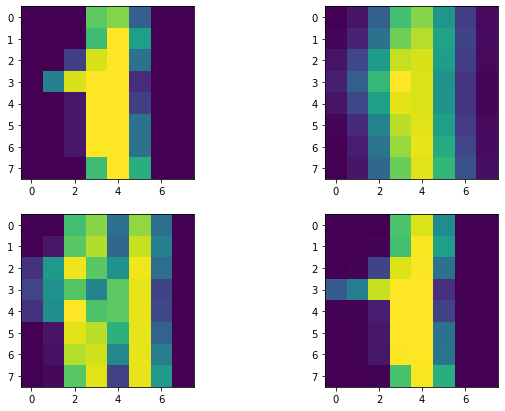

In [17]:
T = X[1]
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 2, 1)
plt.imshow(T)
fig.add_subplot(2, 2, 2)
plt.imshow(filters.gaussian(T))
fig.add_subplot(2, 2, 3)
plt.imshow(filters.sobel(T))
fig.add_subplot(2, 2, 4)
from skimage.restoration import denoise_tv_bregman
plt.imshow(denoise_tv_bregman(T))

In [23]:
X_gauss = []
X_sobel = []
X_breg = []
digits = load_digits()
for im in X:
    im_gauss = filters.gaussian(im)
    X_gauss.append(im_gauss)
    im_sobel = filters.sobel(im)
    X_sobel.append(im_sobel)
    im_breg = denoise_tv_bregman(im)
    X_breg.append(im_breg)


In [24]:
scaler = StandardScaler()
def rescale(collection):
    collection = np.reshape(collection,(1797,64))
    collection = scaler.fit_transform(collection)
    return np.reshape(collection,(1797,8,8))


In [25]:
X = rescale(X)
X_gauss = rescale(X_gauss)
X_sobel = rescale(X_sobel)
X_breg = rescale(X_breg)

In [26]:
B = 10
cubpers = gtda.homology.CubicalPersistence()
diagrams = cubpers.fit_transform(X)
persim  = gtda.diagrams.PersistenceImage(n_bins=B)
def im_2_persim(collection):
    diagrams = cubpers.fit_transform(collection)
    im = persim.fit_transform(diagrams)
    return np.reshape(im,(1797,2*B*B))

In [29]:
diagrams = im_2_persim(X)
diagrams_gauss = im_2_persim(X_gauss)
diagrams_sobel = im_2_persim(X_sobel)
diagrams_breg = im_2_persim(X_breg)

In [31]:
total_diagrams = np.concatenate((diagrams,diagrams_gauss,diagrams_sobel,diagrams_breg),axis = 1)

(1797, 800)


In [33]:
#Load target data
from sklearn.preprocessing import OneHotEncoder
y = digits.target
enc = OneHotEncoder(sparse=False)
labels = enc.fit_transform(y.reshape(-1,1))

In [34]:
#Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(total_diagrams,labels, test_size=0.33, random_state=0)

In [39]:
#Model 1: KNN Classifier
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=13)
cv_results = cross_validate(neigh, total_diagrams, y, cv=3)
print(sorted(cv_results.keys()))
print(cv_results['test_score'])

['fit_time', 'score_time', 'test_score']
[0.34056761 0.33555927 0.34223706]


In [40]:
#Model 2: Boosted Trees.
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(n_estimators = 100,random_state = 0)
cv_results = cross_validate(gb_model, total_diagrams, y, cv=3)
print(sorted(cv_results.keys()))
print(cv_results['test_score'])

['fit_time', 'score_time', 'test_score']
[0.58764608 0.53589316 0.60267112]


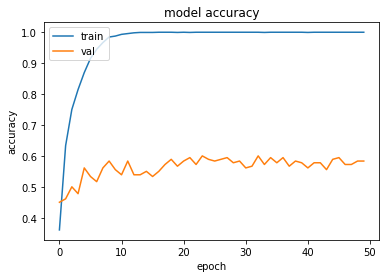

In [41]:
#Model 3: Deep Learning
from keras import models
from keras import layers
np.random.seed(0)
network = models.Sequential()
network.add(layers.Dense(units=100,input_dim = 8*B*B, activation='relu'))
network.add(layers.Dense(units=100, activation='relu'))
network.add(layers.Dense(units=10, activation='softmax'))
network.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')
history = network.fit(total_diagrams, labels,validation_split = 0.1, epochs=50, batch_size=4,verbose=0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

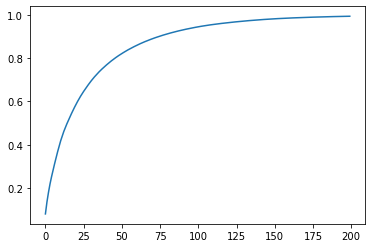

In [69]:
#Let's run these experiments again, now using PCA preprocessing
from sklearn.decomposition import PCA 
pca = PCA(n_components=200)
diagrams_pca = pca.fit_transform(total_diagrams)
plt.plot(np.cumsum(pca.explained_variance_ratio_))


In [70]:
#Model 1: KNN Classifier
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
cv_results = cross_validate(neigh, diagrams_pca, y, cv=3)
print(sorted(cv_results.keys()))
print(cv_results['test_score'])

['fit_time', 'score_time', 'test_score']
[0.30550918 0.30550918 0.31218698]


In [71]:
#Model 2: Boosted Trees.
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(n_estimators = 100,random_state = 0)
cv_results = cross_validate(gb_model,diagrams_pca, y, cv=3)
print(sorted(cv_results.keys()))
print(cv_results['test_score'])

['fit_time', 'score_time', 'test_score']
[0.39732888 0.41402337 0.44240401]


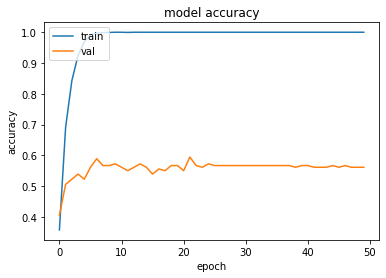

In [72]:
#Model 3: Deep Learning
from keras import models
from keras import layers
np.random.seed(0)
network = models.Sequential()
network.add(layers.Dense(units=100,input_dim = 200, activation='relu'))
network.add(layers.Dense(units=100, activation='relu'))
network.add(layers.Dense(units=10, activation='softmax'))
network.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')
history = network.fit(diagrams_pca, labels,validation_split = 0.1, epochs=50, batch_size=4,verbose=0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()